## Importing Libraries

In [132]:
!pip install neattext

In [133]:
!pip install scikit-multilearn 

In [134]:
!pip install xgboost

In [135]:
import pandas as pd 
import numpy as np 
import re
import string

In [136]:
# text processing libraries
import re
import string
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer



In [137]:
# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set(color_codes=True)

In [138]:
# model related libraries
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# from sklearn.model_selection import train_test_split

In [198]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [201]:
# metrics
from sklearn.metrics import classification_report, multilabel_confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, hamming_loss

In [141]:
# others
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Data Exploration

First let's look at how the data is organized. 

In [142]:
train = pd.read_csv('data/train.csv')
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

#### Then lets make some visualization about the dataset for furhter understanding.

Strating from a simple bar chart that shows the number of comments for each category. 

Text(0.5, 0, '# of categories')

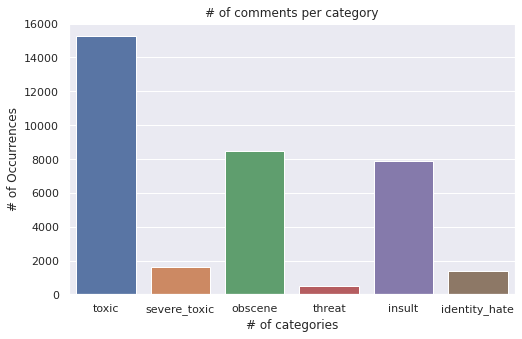

In [143]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 
      'insult', 'identity_hate']
labels_data = train[labels]
label_count = labels_data.sum()
plt.figure(figsize=(8,5))
ax = sns.barplot(label_count.index, label_count.values)
plt.title("# of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [144]:
# test_data = pd.read_csv('data/test.csv')
# test_labels = pd.read_csv('data/test_labels.csv')

Since the categories are not mutally exclusive, let's see how many categories each comment coantains. 

Text(0.5, 0, '# of categories')

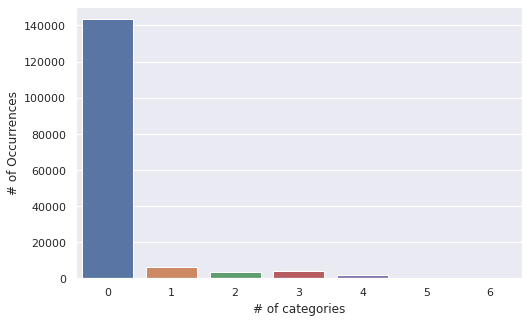

In [145]:
rowsums = data.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

We can see that the dataset is biased towards non-categoized comments. 



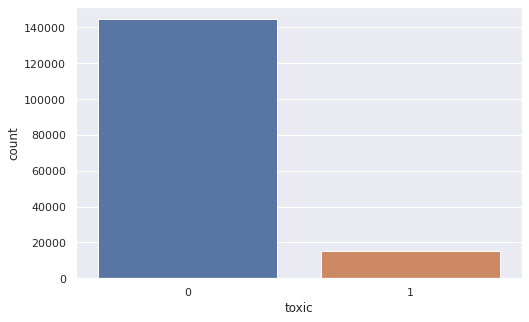

In [146]:
plt.figure(figsize=(8,5))
g = sns.countplot(data['toxic'])
plt.show()

In [147]:
def plot_data(): 
    barWidth = 0.35
    plt.figure(figsize=(8,5))
    bars1 = [sum(train['toxic'] == 1), sum(train['severe_toxic'] == 1), sum(train['obscene'] == 1), sum(train['threat'] == 1),
             sum(train['insult'] == 1), sum(train['identity_hate'] == 1)]
    bars2 = [sum(train['toxic'] == 0), sum(train['severe_toxic'] == 0), sum(train['obscene'] == 0), sum(train['threat'] == 0),
             sum(train['insult'] == 0), sum(train['identity_hate'] == 0)]

    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, bars1, color='steelblue', width=barWidth, label='classified')
    plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='not_classified')

    plt.xlabel('categories')
    plt.ylabel('# of comments')
    plt.xticks([r + barWidth for r in range(len(bars1))], labels)

    plt.legend()
    plt.show()
    pass 

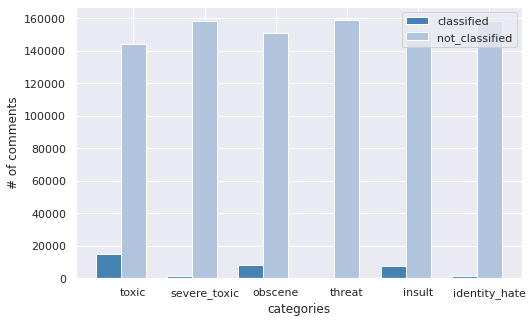

In [148]:
plot_data()

The plot above shows that there is an imbalance dataset. So, to address this issue we will need to drop data that does not fall into any category

In [149]:
# train = pd.read_csv('data/train-processed.csv')
# train.drop('id', axis=1, inplace=True)
data_drop = train[
    (train['toxic'] == 0) & 
    (train['severe_toxic'] == 0) & 
    (train['obscene'] == 0) & 
    (train['threat'] == 0) & 
    (train['insult'] == 0) & 
    (train['identity_hate'] == 0)
         ].sample(frac=1).head(int(len(train)*(55/100)))

train.drop(data_drop.index, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

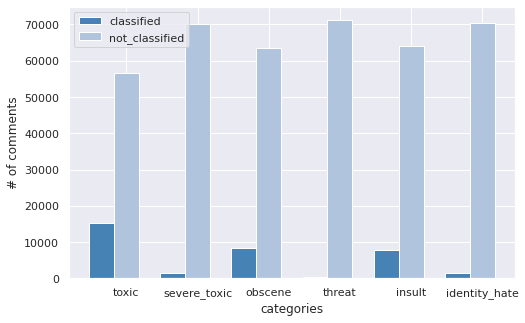

In [150]:
plot_data()

The data does not seem to perform well, when we tried to remove some entris.

So, we need to re-read the origian dataset. 

In [151]:
# train = pd.read_csv('data/data.csv')

## 2. Data Preparation

### Data Preprocessing

For data cleaning we need to define a function to: 
  * `Remove HTML tags`
  * `Convert all letters into lowerecase`
  * `Remove all non-alphapet characters`

In [152]:
import neattext.functions as nfx
import re
from bs4 import BeautifulSoup
# from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(data):
    stemmer = SnowballStemmer(language='english')
    text = BeautifulSoup(data, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text.lower()) # Convert to lower case
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stopwords.words("english")] # Remove stopwords
#     words = [stemmer.stem(w) for w in words] # stem
    words = ' '.join(words)

    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First, let's take a look at a sample origianl comment.

In [153]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Then let's see the same comment after cleaning. 

In [154]:
preprocess_text(train['comment_text'][0])

'explan edit made usernam hardcor metallica fan revert vandal closur gas vote new york doll fac pleas remov templat talk page sinc retir'

Processing all comments in the training set. 

In [155]:
train['comment_text'] = train['comment_text'].apply(preprocess_text)
# data['comment_text'] = [preprocess_text(comment) for comment in data['comment_text']]

In [157]:
train.drop('id', inplace=True, axis=1)
train.reset_index(drop=True, inplace=True)
train.to_csv('data/train-processed.csv')

In [ ]:
# data.to_csv('model_data/train.csv', index=False, header=False)

### Preparing training and testing sets 


The dataset obtained has already provided us with training a testing sets. 

The data above will be our training data, and the upcoming cells will read the testing data and prepare it for the model. 

In [ ]:
# train = data.copy()

In [170]:
# Read test.csv and test_labels files


test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [171]:
test

id                                       comment_text
0       00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1       0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2       00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3       00017563c3f7919a  :If you have a look back at the source, the in...
4       00017695ad8997eb          I don't anonymously edit articles at all.
...                  ...                                                ...
153159  fffcd0960ee309b5  . \n i totally agree, this stuff is nothing bu...
153160  fffd7a9a6eb32c16  == Throw from out field to home plate. == \n\n...
153161  fffda9e8d6fafa9e  " \n\n == Okinotorishima categories == \n\n I ...
153162  fffe8f1340a79fc2  " \n\n == ""One of the founding nations of the...
153163  ffffce3fb183ee80  " \n :::Stop already. Your bullshit is not wel...

[153164 rows x 2 columns]

In [172]:
test_labels

id  toxic  severe_toxic  obscene  threat  insult  \
0       00001cee341fdb12     -1            -1       -1      -1      -1   
1       0000247867823ef7     -1            -1       -1      -1      -1   
2       00013b17ad220c46     -1            -1       -1      -1      -1   
3       00017563c3f7919a     -1            -1       -1      -1      -1   
4       00017695ad8997eb     -1            -1       -1      -1      -1   
...                  ...    ...           ...      ...     ...     ...   
153159  fffcd0960ee309b5     -1            -1       -1      -1      -1   
153160  fffd7a9a6eb32c16     -1            -1       -1      -1      -1   
153161  fffda9e8d6fafa9e     -1            -1       -1      -1      -1   
153162  fffe8f1340a79fc2     -1            -1       -1      -1      -1   
153163  ffffce3fb183ee80     -1            -1       -1      -1      -1   

        identity_hate  
0                  -1  
1                  -1  
2                  -1  
3                  -1  
4                  -1  
...               ...  
153159             -1  
153160             -1  
153161             -1  
153162             -1  
153163             -1  

[153164 rows x 7 columns]

We can see that the testing set is devided into two sets, one conatins the comments ` X ` and the other contains the labels ` y `. Where they are linked via the comment id number. 

We can also notice that some comments conatain label values of  ` -1 `, which according to the dataset source indicates an ingonre signal that does not mean anything. 
So we will drop rows that conatians -1 labels in both data and data_labels sets. 

In [173]:
drop_index = test_labels[
    (test_labels['toxic'] == -1) | 
    (test_labels['severe_toxic'] == -1) | 
    (test_labels['obscene'] == -1) | 
    (test_labels['threat'] == -1) | 
    (test_labels['insult'] == -1) | 
    (test_labels['identity_hate'] == -1)
]['id']

# data.drop(drop_index.id, axis=0, inplace=True)
# data_labels.drop(drop_index.id, axis=0, inplace=True)
# new_df = sales[~sales.CustomerID.isin(badcu)]
test = test[~test.id.isin(drop_index)]
test_labels = test_labels[~test_labels.id.isin(drop_index)]

In [174]:
test

id                                       comment_text
5       0001ea8717f6de06  Thank you for understanding. I think very high...
7       000247e83dcc1211                   :Dear god this site is horrible.
11      0002f87b16116a7f  "::: Somebody will invariably try to add Relig...
13      0003e1cccfd5a40a  " \n\n It says it right there that it IS a typ...
14      00059ace3e3e9a53  " \n\n == Before adding a new product to the l...
...                  ...                                                ...
153150  fff8f64043129fa2  :Jerome, I see you never got around to this…! ...
153151  fff9d70fe0722906  ==Lucky bastard== \n http://wikimediafoundatio...
153154  fffa8a11c4378854  ==shame on you all!!!== \n\n You want to speak...
153155  fffac2a094c8e0e2  MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...
153156  fffb5451268fb5ba  " \n\n == Unicorn lair discovery == \n\n Suppo...

[63978 rows x 2 columns]

In [175]:
test_labels

id  toxic  severe_toxic  obscene  threat  insult  \
5       0001ea8717f6de06      0             0        0       0       0   
7       000247e83dcc1211      0             0        0       0       0   
11      0002f87b16116a7f      0             0        0       0       0   
13      0003e1cccfd5a40a      0             0        0       0       0   
14      00059ace3e3e9a53      0             0        0       0       0   
...                  ...    ...           ...      ...     ...     ...   
153150  fff8f64043129fa2      0             0        0       0       0   
153151  fff9d70fe0722906      0             0        0       0       0   
153154  fffa8a11c4378854      0             0        0       0       0   
153155  fffac2a094c8e0e2      1             0        1       0       1   
153156  fffb5451268fb5ba      0             0        0       0       0   

        identity_hate  
5                   0  
7                   0  
11                  0  
13                  0  
14                  0  
...               ...  
153150              0  
153151              0  
153154              0  
153155              0  
153156              0  

[63978 rows x 7 columns]

`About 70000 rows have been dropped`. 

In [176]:
# drop_index = data_labels[
#     (data_labels['toxic'] == 0) & 
#     (data_labels['severe_toxic'] == 0) & 
#     (data_labels['obscene'] == 0) & 
#     (data_labels['threat'] == 0) & 
#     (data_labels['insult'] == 0) & 
#     (data_labels['identity_hate'] == 0)
#            ].index
# data = data[~data.index.isin(drop_index)]
# data_labels = data_labels[~data_labels.index.isin(drop_index)]

In [177]:
# data

In [178]:
# data_labels

Since id column is used only for administrative purposees, we can drop it. 

In [179]:
test.drop('id', axis=1, inplace=True)
test_labels.drop('id', axis=1, inplace=True)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [180]:
# processing testing set comments. 
test['comment_text'] = test['comment_text'].apply(preprocess_text)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Half-Life_%28series%29" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://es.wikipedia.org/wiki/Usuario_Discusi%C3%B3n:Sarah_W." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Rayleigh%E2%80%93B%C3%A9nard_convection" looks like a U

In [181]:
data

Unnamed: 0                                       comment_text  toxic  \
0                0  explan edit made usernam hardcor metallica fan...      0   
1                1  aww match background colour seem stuck thank t...      0   
2                2  hey man realli tri edit war guy constant remov...      0   
3                3  make real suggest improv wonder section statis...      0   
4                4                         sir hero chanc rememb page      0   
...            ...                                                ...    ...   
159566      159566  second time ask view complet contradict covera...      0   
159567      159567                  asham horribl thing put talk page      0   
159568      159568  spitzer umm there actual articl prostitut ring...      0   
159569      159569  look like actual put speedi first version dele...      0   
159570      159570  realli think understand came idea bad right aw...      0   

        severe_toxic  obscene  threat  insult  identity_hate  
0                  0        0       0       0              0  
1                  0        0       0       0              0  
2                  0        0       0       0              0  
3                  0        0       0       0              0  
4                  0        0       0       0              0  
...              ...      ...     ...     ...            ...  
159566             0        0       0       0              0  
159567             0        0       0       0              0  
159568             0        0       0       0              0  
159569             0        0       0       0              0  
159570             0        0       0       0              0  

[159571 rows x 8 columns]

In [182]:
test.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

In [183]:
test.to_csv('data/test-processed.csv')
test_labels.to_csv('data/test_labels-processed.csv')

## 3. Modeling

Since we have a huge set of data, and extracting text_features using TfidfVectorizer that will be fed to the model will require a huge amount of memory.

We will use sklearn's `Pipline` to extract features from comments and train the model through piplining over each row, to save space. 

To do that we will define a function that will generate a pipline with the same vectorizer properties for differernt classifiers. 

In [184]:
def define_model(Classifier):
    model = Pipeline([
                    ('tfidf', TfidfVectorizer(
                        strip_accents='unicode',     
                        analyzer='word',            
                        token_pattern=r'\w{1,}',    
                        ngram_range=(1, 3),         
                        stop_words='english',
                        sublinear_tf=True)
                    ),
                    ('clf', Classifier)
                ])
    return model
    pass

In [185]:
X_train = train['comment_text']
y_train = train[labels]
X_test = test['comment_text']
y_test = test_labels

In [186]:
X_test

0        thank understand think high would revert witho...
1                                    dear god site horribl
2        somebodi invari tri add religion realli mean w...
3        say right type type institut need case three l...
4        ad new product list make sure relev ad new pro...
                               ...                        
63973    jerom see never got around surpris look exampl...
63974    lucki bastard http wikimediafound org wiki pre...
63975                        shame want speak gay romanian
63976    mel gibson nazi bitch make shitti movi much bu...
63977    unicorn lair discoveri suppos unicorn lair dis...
Name: comment_text, Length: 63978, dtype: object

In [187]:
def train_and_test(x_train, y_train, x_test, y_test, model, labels):
#     predecition_df = pd.DataFrame()
#     for category in labels:
#         print('... Processing {}'.format(category))
#         # train the model using X_dtm & y
#         model.fit(x_train, y_train[category])
#         # compute the testing accuracy
#         prediction = model.predict(x_test)
# #         print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
# #         print('Test accuracy is {}'.format(hamming_loss(y_test[category], prediction)))
#         predecition_df[category] = prediction
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    return prediction
    pass



#### We will use `OneVsRestClassifier` for each of the following models


### MultinomialNB

In [202]:
scores = pd.DataFrame(columns=['Model', 'Recall'])

In [188]:
model = define_model(OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)))
MNB_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [189]:
confusion_matrix = multilabel_confusion_matrix(y_test, MNB_pred)
confusion_matrix

array([[[57740,   148],
        [ 4734,  1356]],

       [[63611,     0],
        [  367,     0]],

       [[60282,     5],
        [ 3346,   345]],

       [[63767,     0],
        [  211,     0]],

       [[60549,     2],
        [ 3321,   106]],

       [[63266,     0],
        [  712,     0]]])

In [206]:
print(classification_report(
    y_test,
    MNB_pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.90      0.22      0.36      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.99      0.09      0.17      3691
       threat       0.00      0.00      0.00       211
       insult       0.98      0.03      0.06      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.92      0.12      0.22     14498
    macro avg       0.48      0.06      0.10     14498
 weighted avg       0.86      0.12      0.21     14498
  samples avg       0.02      0.01      0.01     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

we can see from the confusion_matrix that MultinomialNB did not perform well in predicting severe_toxic, threat, and identity_hate. 

### LogisticRegression

In [191]:
model = define_model(OneVsRestClassifier(LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=100)))
LR_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [192]:
confusion_matrix = multilabel_confusion_matrix(y_test, LR_pred)
confusion_matrix

array([[[52263,  5625],
        [  737,  5353]],

       [[63157,   454],
        [  191,   176]],

       [[58269,  2018],
        [  801,  2890]],

       [[63632,   135],
        [  128,    83]],

       [[58507,  2044],
        [  913,  2514]],

       [[62874,   392],
        [  321,   391]]])

In [193]:
print(classification_report(
    y_test,
    LR_pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.49      0.88      0.63      6090
 severe_toxic       0.28      0.48      0.35       367
      obscene       0.59      0.78      0.67      3691
       threat       0.38      0.39      0.39       211
       insult       0.55      0.73      0.63      3427
identity_hate       0.50      0.55      0.52       712

    micro avg       0.52      0.79      0.62     14498
    macro avg       0.46      0.64      0.53     14498
 weighted avg       0.52      0.79      0.62     14498
  samples avg       0.07      0.08      0.07     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LinearSVC

In [ ]:
from sklearn.svm import SVC
model = define_model(OneVsRestClassifier(SVC(gamma='scale', class_weight='balanced'), n_jobs=1))
OSVC_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [ ]:
confusion_matrix = multilabel_confusion_matrix(y_test, OSVC_pred)
confusion_matrix

In [ ]:
print(classification_report(
    y_test,
    OSVC_pred,
    output_dict=False,
    target_names=labels
))

#### XGBoost

In [199]:
model = define_model(OneVsRestClassifier(xgb.XGBClassifier()))
xgb_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    xgb_pred,
    output_dict=False,
    target_names=labels
))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:22:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:25:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:26:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4. Result Evaluation

### LinearSVC (all data)
    precision    recall  f1-score   support

    toxic       0.55      0.84      0.67      6090
    severe_toxic       0.34      0.41      0.37       367
    obscene       0.60      0.77      0.68      3691
    threat       0.51      0.27      0.35       211
    insult       0.59      0.70      0.64      3427
    identity_hate       0.65      0.41      0.50       712

    micro avg       0.57      0.75      0.65     14498
    macro avg       0.54      0.56      0.53     14498
    weighted avg       0.57      0.75      0.64     14498
    samples avg       0.07      0.07      0.07     14498